## Context
Predicting loan approval using data is essential due to its ability to enhance decision-making, mitigate risks, improve efficiency, ensure fairness, and aid in portfolio management. Leveraging data enables lenders to make informed choices by analyzing applicants' financial histories objectively, reducing reliance on subjectivity. Data-driven predictions help identify potential default risks and allow lenders to adjust terms or deny loans when necessary. This approach streamlines the loan application process, expediting responses and improving the applicant experience. Additionally, data-driven loan approval ensures compliance with regulations, minimizes biases, and enables lenders to tailor strategies for optimized risk management and decision alignment with business goals.

The train dataset contains 614 instances and 12 attributes, of which 5 are quantitative input variables,  6 are qualitative input variables, and 1 qualitative output variable. The test dataset contains 367 instances and 11 attributes. Furthermore, the datasets contain a total of 206 missing values and is in raw form.

## Content
The feature set includes:

* Gender: Gender of the person - Male, Female.
* Married: Whether the person is married - Yes, No.
* Dependents: Number of children.
* Education: Education of the person - Graduate, Not Graduate.
* Self_Employed: Whether the person is self-employed - Yes, No.
* Applicant_Income: Income of the applicant.
* Coapplicant_Income: Income of the co-applicant.
* Loan_Amount: Amount of the requested loan.
* Term: Amount of time that the borrower has to repay the loan.
* Credit_History: Representation of a person's creditworthiness, where 0.0 refers to bad credit and 1.0 refers to good credit.
* Area: Residential region of the person - Urban, Rural, Semi-Urban.
* Status: Whether the loan request was approved - Y, N.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import feature engineering libraries 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from hyperopt import hp, tpe, fmin, Trials, space_eval

# Import performance metrics libraries
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Import classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the datasets
train_data = pd.read_csv("/kaggle/input/loan-data-set/loan_train.csv")
test_data = pd.read_csv("/kaggle/input/loan-data-set/loan_test.csv")

# Create a copy of the datasets
train_df = train_data.copy()
test_df = test_data.copy()

# Define the target variable
TARGET = "Status"

In [3]:
# Print the shape of the datasets
print(f"The train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"The test dataset has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

The train dataset has 614 rows and 12 columns.
The test dataset has 367 rows and 11 columns.


In [4]:
# Show the first 5 rows of the training dataset
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [5]:
# Return general information about the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              601 non-null    object 
 1   Married             611 non-null    object 
 2   Dependents          599 non-null    object 
 3   Education           614 non-null    object 
 4   Self_Employed       582 non-null    object 
 5   Applicant_Income    614 non-null    int64  
 6   Coapplicant_Income  614 non-null    float64
 7   Loan_Amount         614 non-null    int64  
 8   Term                600 non-null    float64
 9   Credit_History      564 non-null    float64
 10  Area                614 non-null    object 
 11  Status              614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB


In [6]:
# Return the number of missing values for each column
train_df.isna().sum()

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                  14
Credit_History        50
Area                   0
Status                 0
dtype: int64

In [7]:
# Return the number of missing values for each column
test_df.isna().sum()

Gender                11
Married                0
Dependents            10
Education              0
Self_Employed         23
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                   6
Credit_History        29
Area                   0
dtype: int64

In [8]:
# Return descriptive statistics of the dataset
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Applicant_Income,614.0,5.403459e+05,6.109042e+05,15000.0,287750.0,381250.0,579500.0,8100000.0
Coapplicant_Income,614.0,1.621246e+05,2.926248e+05,0.0,0.0,118850.0,229725.0,4166700.0
Loan_Amount,614.0,1.414104e+07,8.815682e+06,0.0,9800000.0,12500000.0,16475000.0,70000000.0
Term,600.0,3.420000e+02,6.512041e+01,12.0,360.0,360.0,360.0,480.0
Credit_History,564.0,8.421986e-01,3.648783e-01,0.0,1.0,1.0,1.0,1.0


In [9]:
def select_columns(df: pd.DataFrame, threshold: int = 10) -> list[str]:
    """
    Function used to divide the columns of a DataFrame in discrete and continuous based on the specified threshold.

    Args:
        df (pd.DataFrame): A DataFrame containing the columns to be selected.
        threshold (int): A threshold defining the minimum number of unique values. Default is 10.

    Returns:
        discrete_columns (list[str]): A list of discrete column names.
        continuous_columns (list[str]): A list of continuous column names.
    """
    
    # Initialize the discrete and continuous columns lists
    discrete_columns = []
    continuous_columns = []

    for column in df.columns:
        # Select the columns with number of unique values less than or equal to the threshold
        if df[column].nunique() <= threshold:
            # Append the selected columns to the list of discrete columns
            discrete_columns.append(column)
        # Select the columns with number of unique values greater than the threshold
        else:
            continuous_columns.append(column)


    return discrete_columns, continuous_columns

In [10]:
# Apply the select_columns function
discrete_columns, continuous_columns = select_columns(train_df)

In [11]:
# Return the discrete and continuous columns
discrete_columns, continuous_columns

(['Gender',
  'Married',
  'Dependents',
  'Education',
  'Self_Employed',
  'Term',
  'Credit_History',
  'Area',
  'Status'],
 ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount'])

In [12]:
def visualizations_discrete(df: pd.DataFrame):
    """
    Function used to plot countplots for each discrete column.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
    """

    # Set the figure size and layout
    fig, axes = plt.subplots(nrows=len(discrete_columns), ncols=2, figsize=(12, 6 * len(discrete_columns)))
    plt.tight_layout(pad=2.0)
    
    for index, column in enumerate(discrete_columns):
        # Plot countplot
        sns.countplot(data=df, x=column, ax=axes[index, 0], palette="blend:#7AB,#EDA")
        axes[index, 0].set_title(f"Countplot of {column}")
        axes[index, 0].set_xlabel("")

        # Plot countplot
        sns.countplot(data=df, x=column, hue=TARGET, ax=axes[index, 1], palette="blend:#7AB,#EDA")
        axes[index, 1].set_title(f"Countplot of {column} specified by {TARGET}")
        axes[index, 1].set_xlabel("")  

    # Show the plot
    plt.show()

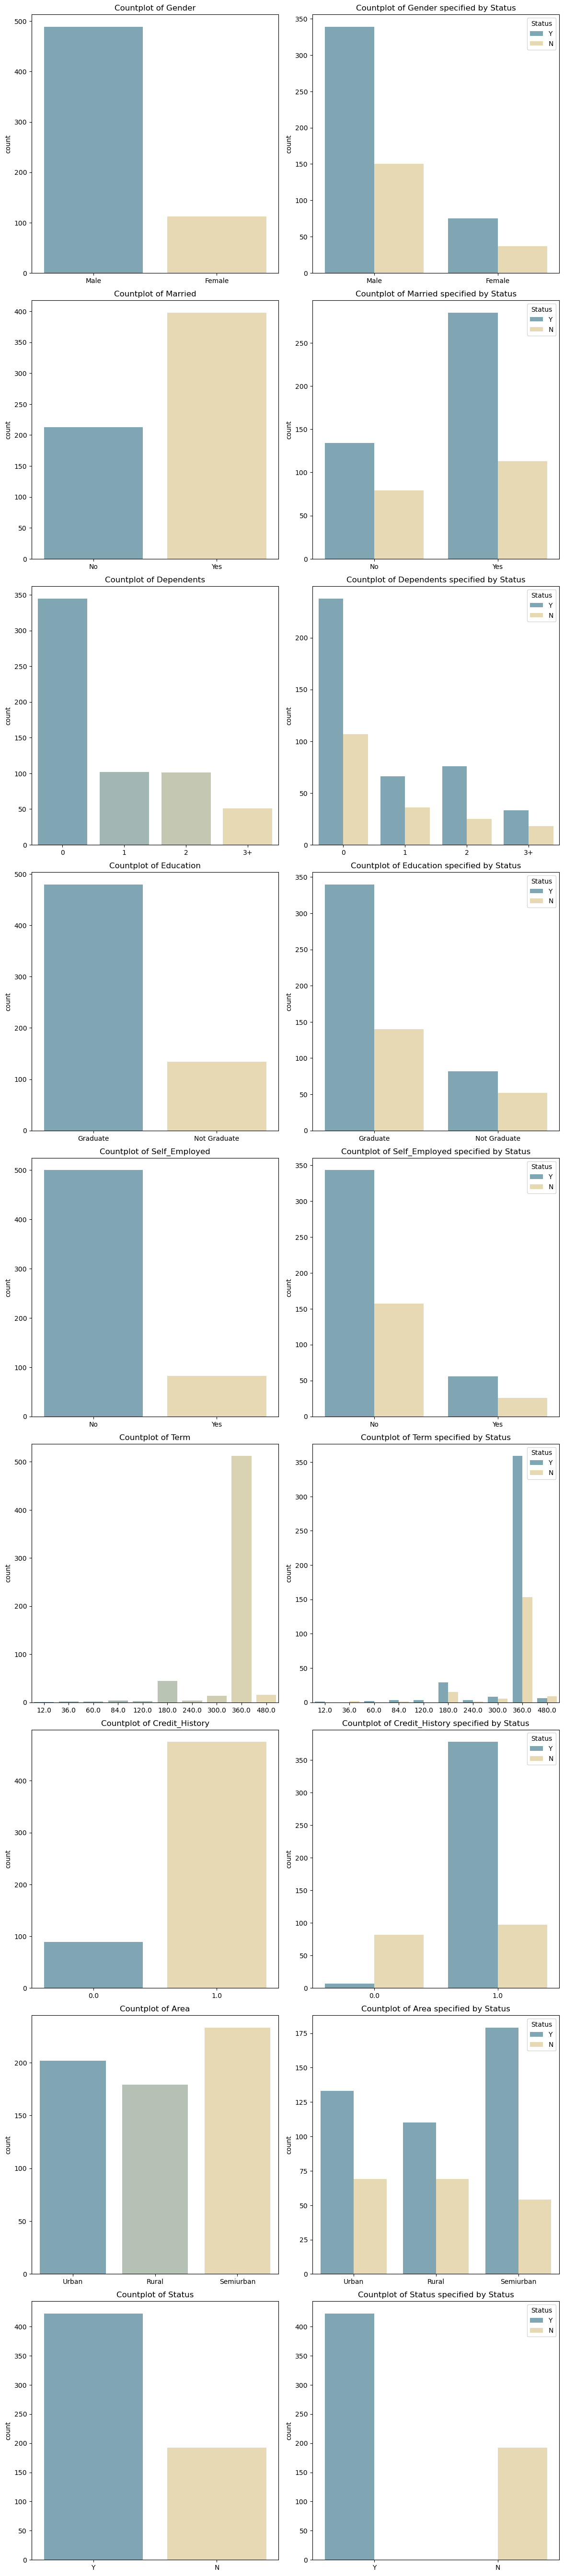

In [13]:
# Apply the visualizations_discrete function
visualizations_discrete(train_df)

Based on the figures above, the following conclusions can be drawn:
* The number of men and women in the dataset is unevenly distributed. However, the difference in loan approval status between men and women appears to be fairly consistent.
* The number of accepted loan requests is higher for graduates than for non-graduates.
* Credit history is an important indicator for whether or not to receive a loan.
* The number of requests per type of region is approximately evenly distributed. However, it is noticeable that requests from semi-urban regions are more frequently accepted.

In [14]:
def visualizations_continuous(df: pd.DataFrame):
    """
    Function used to plot the boxplot and distribution for each continuous column.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
    """
    
    # Set the figure size and layout
    fig, axes = plt.subplots(nrows=len(continuous_columns), ncols=2, figsize=(12, 6 * len(continuous_columns)))
    fig.tight_layout(pad=2.0)

    for index, column in enumerate(continuous_columns):
        # Plot boxplot
        sns.boxplot(data=df, x=TARGET, y=column, ax=axes[index, 0], palette="blend:#7AB,#EDA")
        axes[index, 0].set_title(f"Boxplot of {column}")
        axes[index, 0].set_xlabel("")

        # Plot distribution
        sns.histplot(data=df, x=column, kde=True, ax=axes[index, 1], palette="blend:#7AB,#EDA")
        axes[index, 1].set_title(f"Distribution of {column}")
        axes[index, 1].set_xlabel("")
        
    # Show the plot
    plt.show()

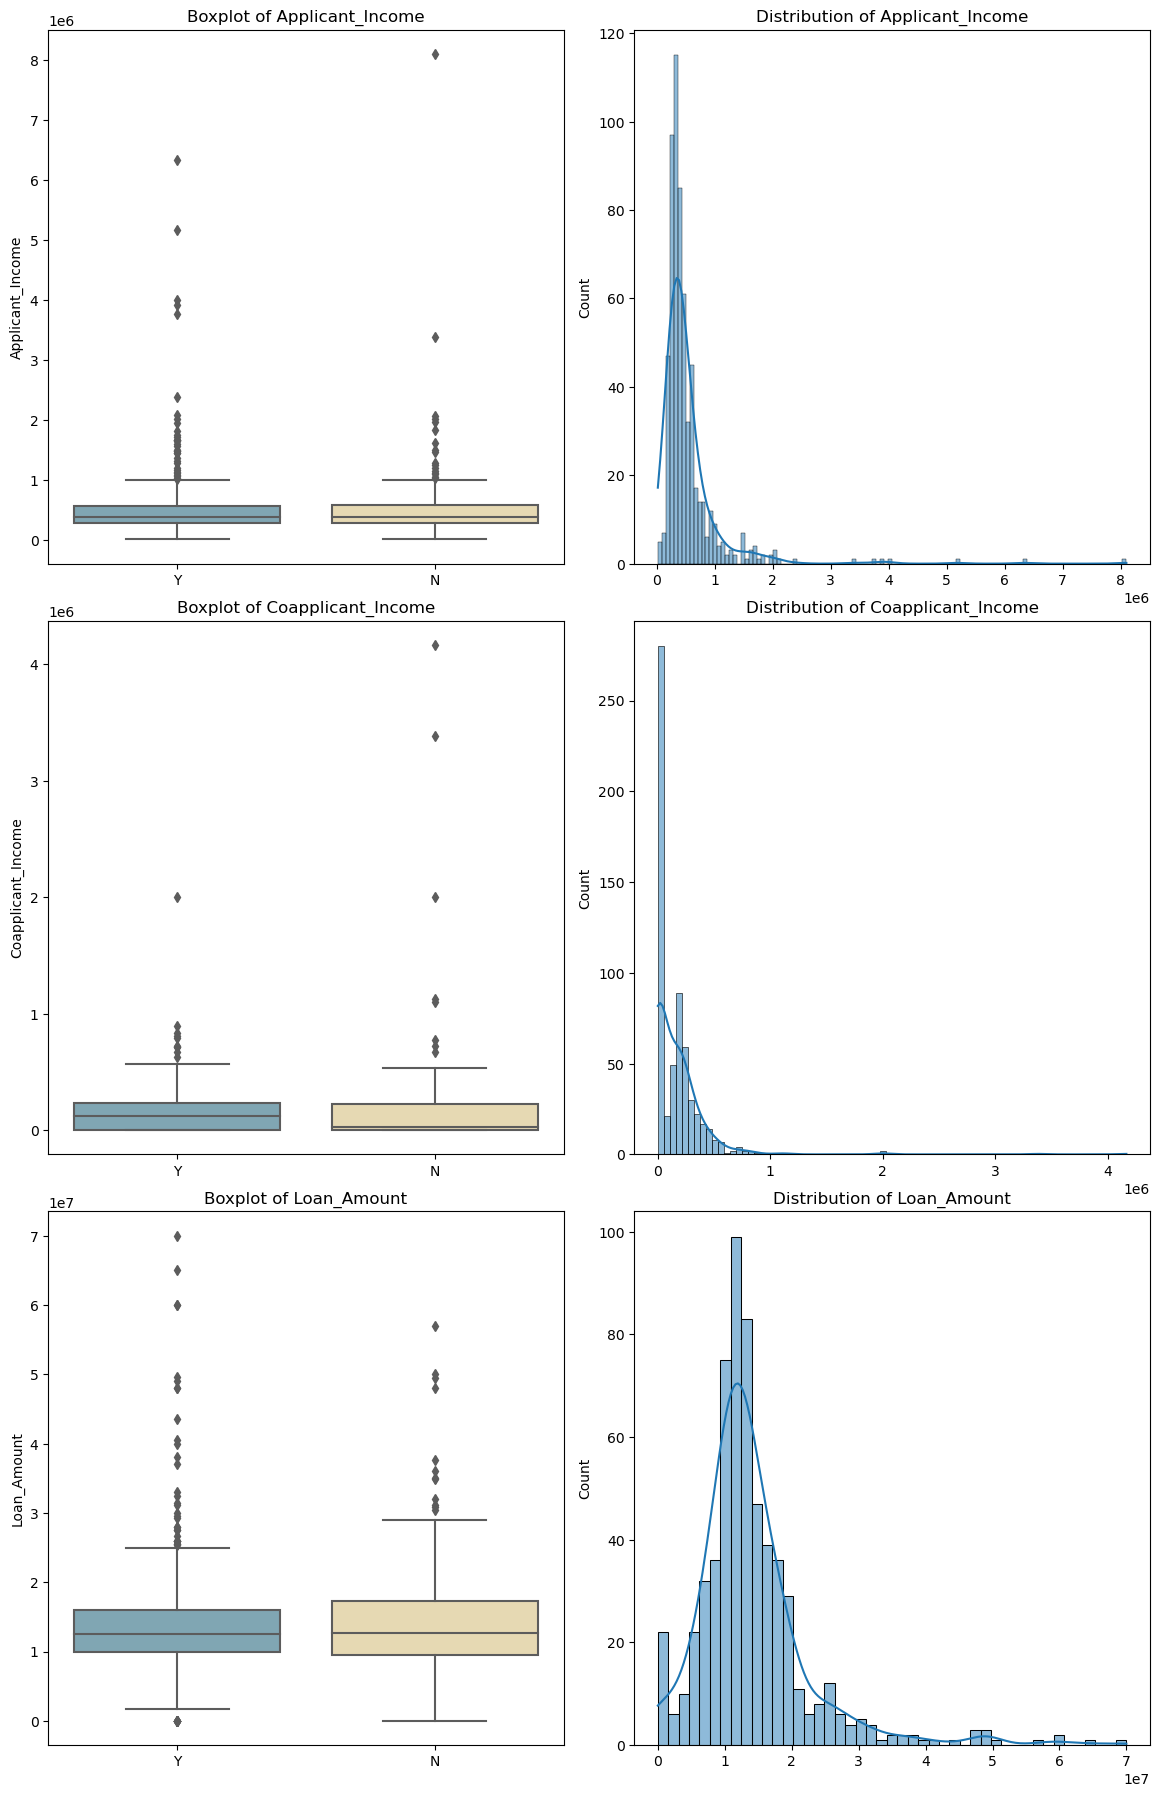

In [15]:
# Apply the visualizations_continuous function
visualizations_continuous(train_df)

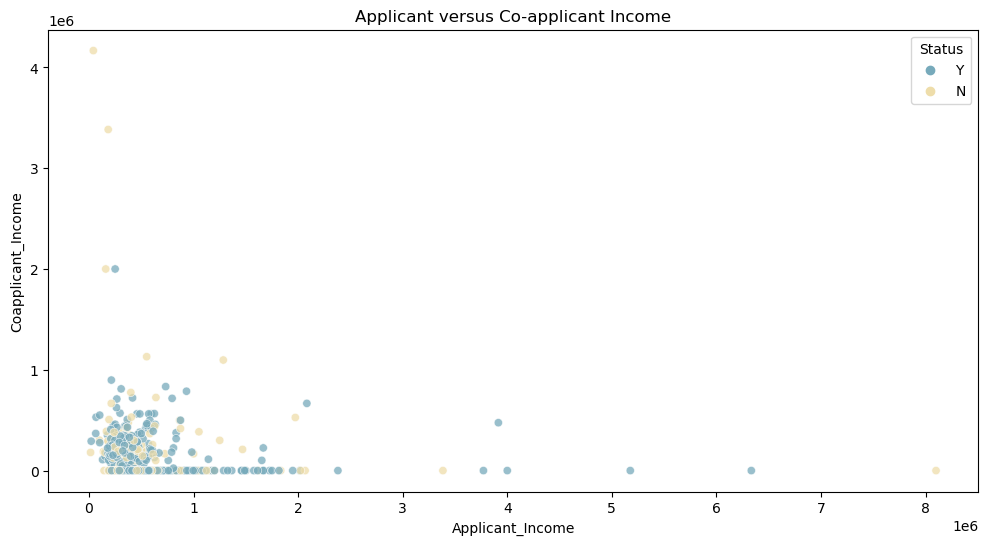

In [16]:
# Set the figure size and layout
plt.figure(figsize=(12,6), dpi=100)
plt.tight_layout(pad=2.0)

# Plot the relationship between applicant and co-applicant income
sns.scatterplot(data=train_df, x="Applicant_Income", y="Coapplicant_Income", hue=TARGET, palette="blend:#7AB,#EDA", alpha=0.75)
plt.title("Applicant versus Co-applicant Income")

# Show the plot
plt.show()

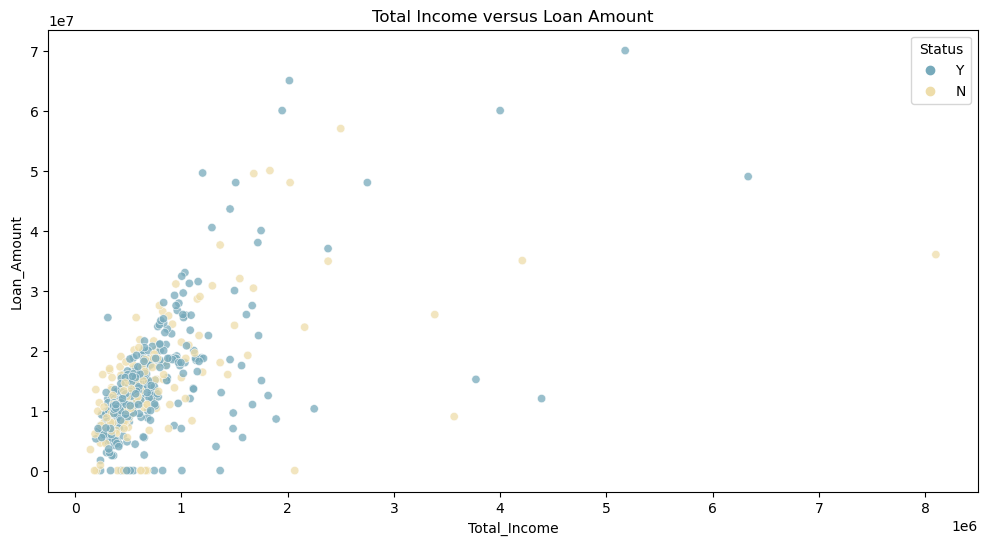

In [17]:
# Create a new column with the total income
train_df["Total_Income"] = train_df["Applicant_Income"] + train_df["Coapplicant_Income"]

# Set the figure size and layout
plt.figure(figsize=(12,6), dpi=100)
plt.tight_layout(pad=2.0)

# Plot the relationship between total income and loan amount
sns.scatterplot(data=train_df, x="Total_Income", y="Loan_Amount", hue=TARGET, palette="blend:#7AB,#EDA", alpha=0.75)
plt.title("Total Income versus Loan Amount")

# Show the plot
plt.show()

In [18]:
def replace_outliers(df: pd.DataFrame, inner_fence_multiplier: float = 1.5, outer_fence_multiplier: float = 3.0) -> pd.DataFrame:
    """
    Function used to replace outliers in each continuous column with the mean value.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.
        - inner_fence_multiplier (float): A multiplier to determine the inner fence. Default is 1.5.
        - outer_fence_multiplier (float): A multiplier to determine the outer fence. Default is 3.0.

    Returns:
        - df (pd.DataFrame): A DataFrame with outliers replaced by the mean value.
    """

    for column in continuous_columns:
        # Calculate the Interquartile Range (IQR)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the inner and outer fences
        inner_fence_low = Q1 - inner_fence_multiplier * IQR
        inner_fence_high = Q3 + inner_fence_multiplier * IQR
        outer_fence_low = Q1 - outer_fence_multiplier * IQR
        outer_fence_high = Q3 + outer_fence_multiplier * IQR

        # Identify the outliers using the inner and outer fences
        outliers = (df[column] < inner_fence_low) | (df[column] > inner_fence_high) | \
                   (df[column] < outer_fence_low) | (df[column] > outer_fence_high)

        # Replace the outliers with the mean value
        df.loc[outliers, column] = df[column].mean()


    return df

In [19]:
# Apply the replace_outliers function to the datasets
train_df = replace_outliers(train_df)
test_df = replace_outliers(test_df)

In [20]:
def replace_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function used to replace missing values in each continuous column with the mean value.

    Parameters:
        - df (pd.DataFrame): A DataFrame containing the data.

    Returns:
        - df (pd.DataFrame): A DataFrame without missing values.
    """
    
    subset_discrete_columns = [column for column in discrete_columns if column != TARGET]

    for column_discrete in subset_discrete_columns:
        # Select the columns with missing values
        if df[column_discrete].isnull().any():
            # Replace the missing values with the mode value
            df[column_discrete] = df[column_discrete].fillna(df[column_discrete].mode()[0])

    for column_continuous in continuous_columns:
        # Select the columns with missing values
        if df[column_continuous].isnull().any():
            # Replace the missing values with the mean value
            df[column_continuous] = df[column_continuous].fillna(df[column_continuous].mean())


    
    return df

In [21]:
# Apply the replace_missing_values function to the datasets
train_df = replace_missing_values(train_df)
test_df = replace_missing_values(test_df)

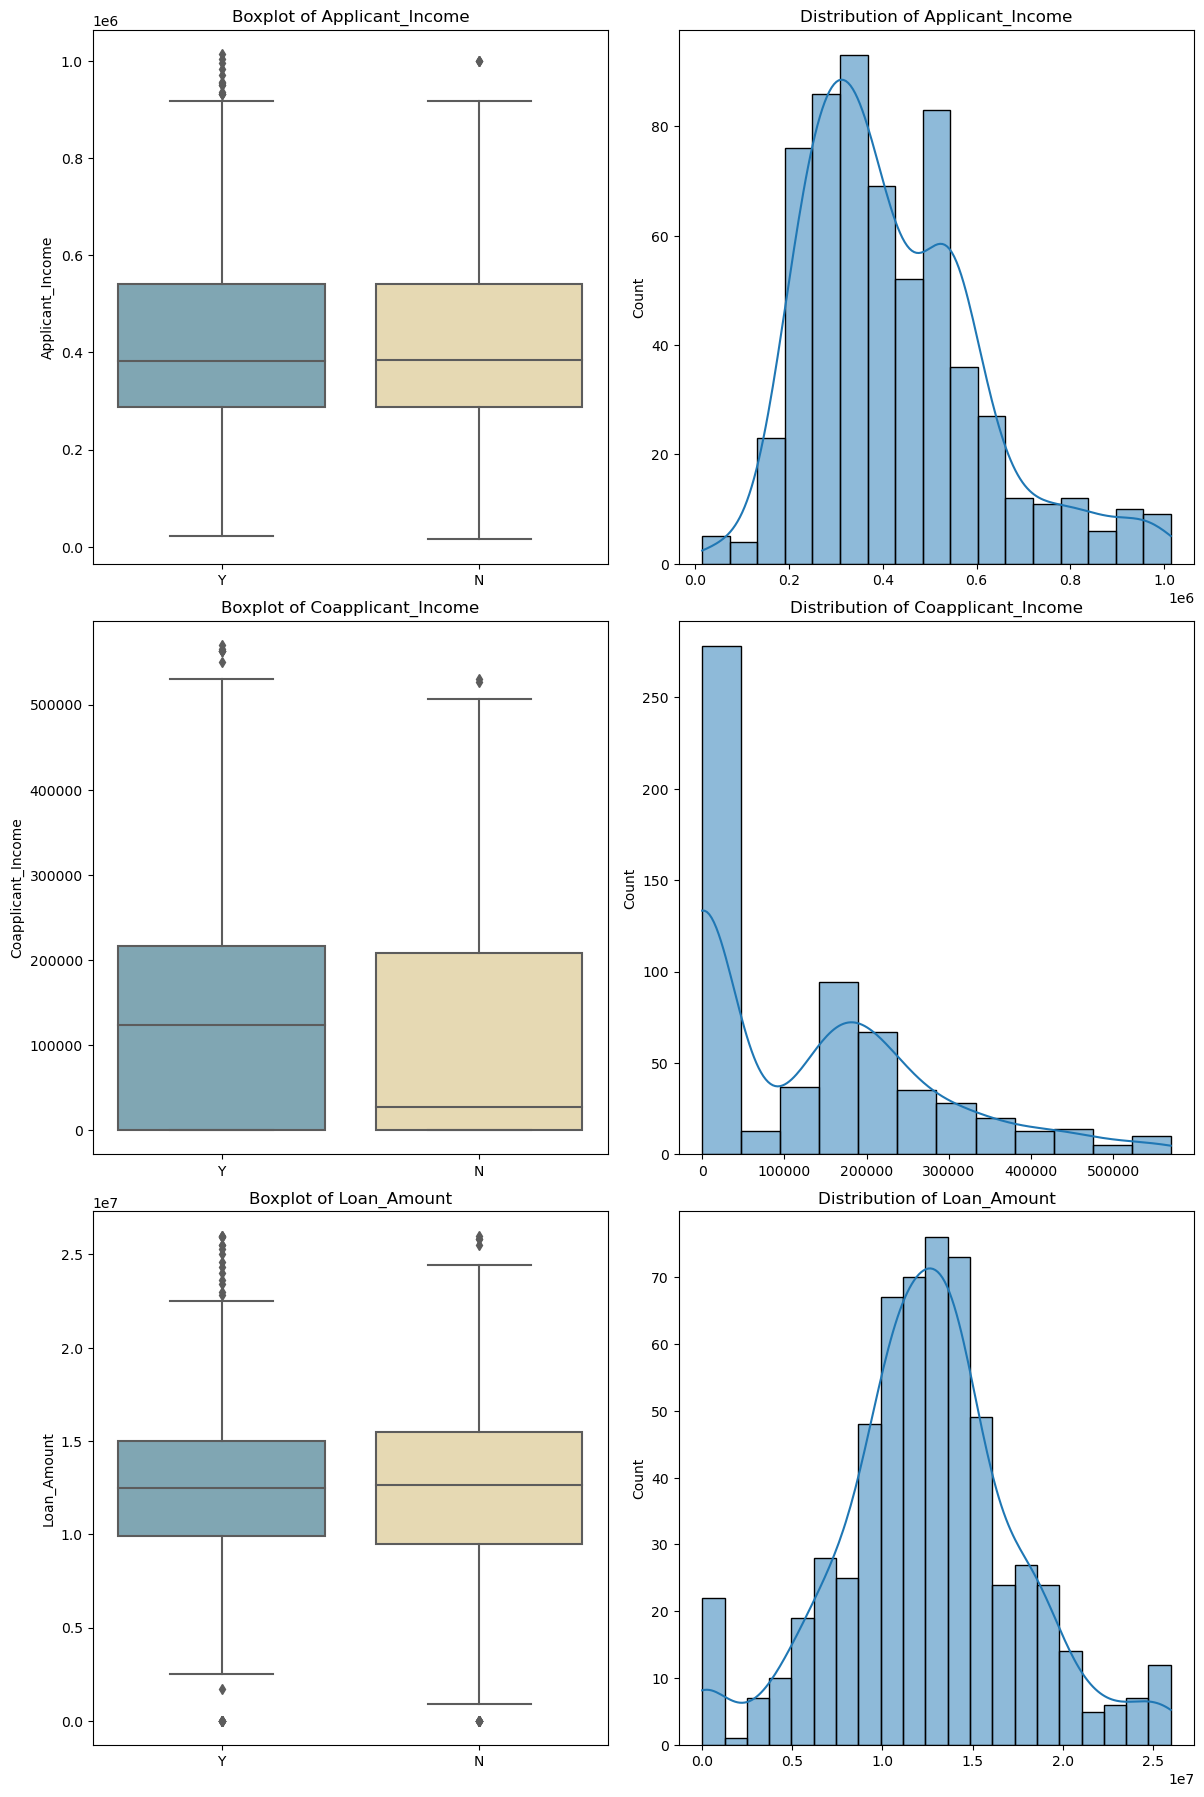

In [22]:
# Re-apply the visualizations_continuous function
visualizations_continuous(train_df)

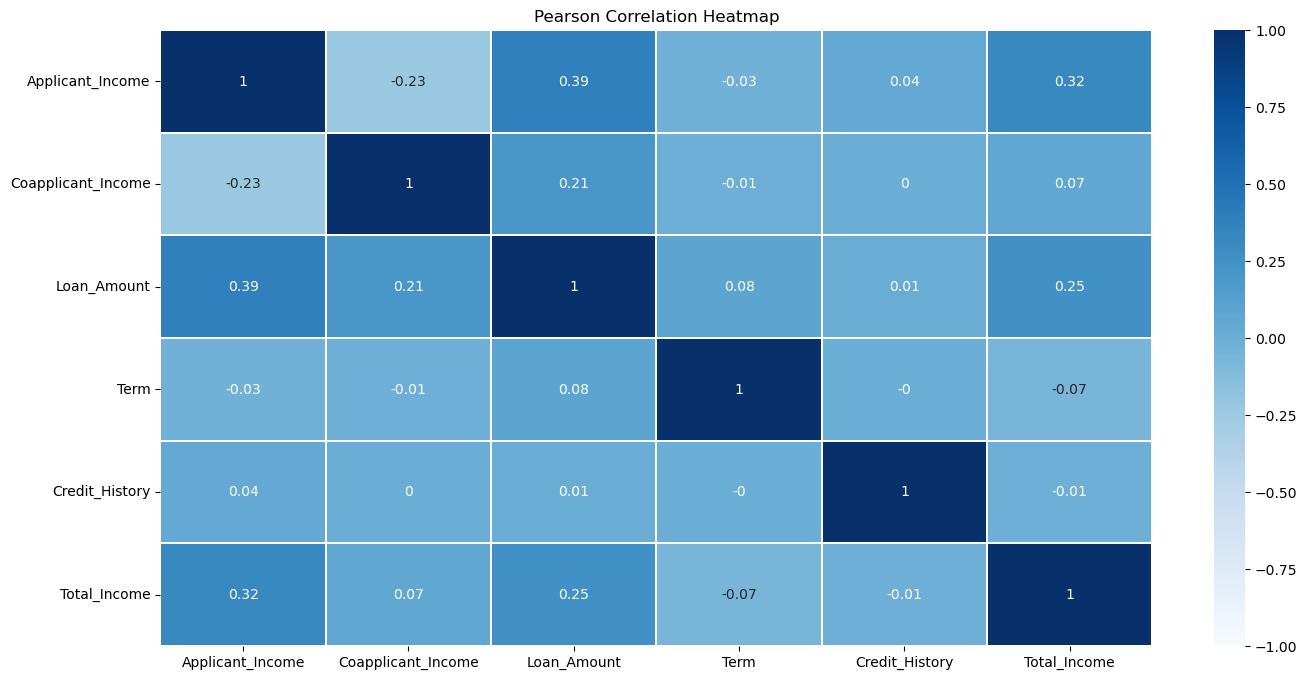

In [23]:
# Set the figure size and layout
plt.figure(figsize=(16,8))
plt.tight_layout(pad=2.0)

# Plot the correlation between the features
corr_matrix = train_df.corr().round(2)
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidths=0.2, fmt=".2g", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")

# Show the plot
plt.show()

In [24]:
# Define the label encoder and the ordinal encoder
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()

# Columns for label and ordinal encoding
label_columns_train = ["Gender", "Married", "Education", "Self_Employed", "Area", "Status"]
label_columns_test = [column for column in label_columns_train if column != TARGET]
ordinal_columns = ["Dependents"]

# Apply the label encoder
train_df[label_columns_train] = train_df[label_columns_train].apply(label_encoder.fit_transform)
test_df[label_columns_test] = test_df[label_columns_test].apply(label_encoder.fit_transform)

# Apply the ordinal encoder
train_df[ordinal_columns] = ordinal_encoder.fit_transform(train_df[ordinal_columns])
test_df[ordinal_columns] = ordinal_encoder.fit_transform(test_df[ordinal_columns])

In [25]:
# Split the dataset into X_train, X_test, y_train, and y_test
X = train_df.drop(columns=[TARGET], axis=1)
y = train_df[TARGET]

In [26]:
# Prespecify the random state
RANDOM_STATE = 2

# Perform a train|-test split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Return the size of X_train and X_test
print(f"Size of training data: {X_train.shape[0]} rows and {X_train.shape[1]} columns.")
print(f"Size of testing data: {X_test.shape[0]} rows and {X_test.shape[1]} columns.")

Size of training data: 429 rows and 12 columns.
Size of testing data: 185 rows and 12 columns.


In [27]:
# Define the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

In [28]:
# Define the oversampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)

# Oversample the minority class
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_scaled, y_train)

# Define the undersampler
undersampler = RandomUnderSampler(random_state=RANDOM_STATE)

# Undersample the majority class
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_scaled, y_train)

In [29]:
# Define the base models to be trained and evaluated
base_models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBClassifier": XGBClassifier(random_state=RANDOM_STATE),
    "BaggingClassifier": BaggingClassifier(random_state=RANDOM_STATE),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "CatBoostClassifier": CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
}

In [30]:
def train_and_evaluate_models_with_sampling(models: dict) -> pd.DataFrame:
    """
    Function used to fit, predict, and evaluate different models using both oversampling and undersampling.

    Parameters:
        - models (dict): A dictionary of model names and model objects.

    Returns:
        - base_results (pd.DataFrame): A DataFrame containing the performance for each base model.
    """
    
    # Initialize the base results DataFrame
    base_results = pd.DataFrame(columns=["Accuracy", "Recall", "Precision", "F1"])

    for model_name, model in models.items():
    # Train the model on oversampled data
        # Fit the model
        model.fit(X_train_oversampled, y_train_oversampled)

        # Predict the target variable
        y_pred_oversampled = model.predict(X_test_scaled)

        # Calculate the evaluation metrics
        accuracy_oversampled = round(accuracy_score(y_test, y_pred_oversampled),3)
        recall_oversampled = round(recall_score(y_test, y_pred_oversampled),3)
        precision_oversampled = round(precision_score(y_test, y_pred_oversampled),3)
        f1_oversampled = round(f1_score(y_test, y_pred_oversampled),3)

        # Store the results in the DataFrame
        base_results.loc[f"{model_name} (Oversampled)"] = [accuracy_oversampled, recall_oversampled,
                                                      precision_oversampled, f1_oversampled]
        
    # Train the model on undersampled data
        # Fit the model
        model.fit(X_train_undersampled, y_train_undersampled)

        # Predict the target variable
        y_pred_undersampled = model.predict(X_test_scaled)

        # Calculate the evaluation metrics
        accuracy_undersampled = round(accuracy_score(y_test, y_pred_undersampled),3)
        recall_undersampled = round(recall_score(y_test, y_pred_undersampled),3)
        precision_undersampled = round(precision_score(y_test, y_pred_undersampled),3)
        f1_undersampled = round(f1_score(y_test, y_pred_undersampled),3)

        # Store the results in the DataFrame
        base_results.loc[f"{model_name} (Undersampled)"] = [accuracy_undersampled, recall_undersampled,
                                                       precision_undersampled, f1_undersampled]

    # Sort the base results in descending order of F1
    base_results.sort_values(by="F1", ascending=False, inplace=True)


    return base_results

In [31]:
# Apply the train_and_evaluate_models_with_sampling function
base_results = train_and_evaluate_models_with_sampling(base_models)

In [32]:
# Show the results of the trained and evaluated models
base_results

,Accuracy,Recall,Precision,F1
RandomForestClassifier (Oversampled),0.811,0.953,0.807,0.874
CatBoostClassifier (Oversampled),0.789,0.945,0.789,0.860
XGBClassifier (Oversampled),0.773,0.898,0.797,0.844
GradientBoostingClassifier (Oversampled),0.762,0.898,0.786,0.838
LogisticRegression (Oversampled),0.757,0.898,0.781,0.835
LogisticRegression (Undersampled),0.751,0.898,0.776,0.832
BaggingClassifier (Oversampled),0.762,0.835,0.822,0.828
CatBoostClassifier (Undersampled),0.714,0.803,0.785,0.794
XGBClassifier (Undersampled),0.719,0.756,0.821,0.787
GradientBoostingClassifier (Undersampled),0.714,0.772,0.803,0.787


In [33]:
def tune_and_evaluate_models(gridsearch_model: dict, param_space: dict) -> pd.DataFrame:
    """
    Function used to tune the hyperparameters of selected models and evaluate the tuned models.

    Parameters:
        - gridsearch_model (dict): A dictionary of model names and model objects.
        - param_space (dict): A dictionary of model names and parameter grids for hyperparameter tuning.

    Returns:
        - tuned_results (pd.DataFrame): A DataFrame containing the performance for each model, including the tuned and base models.
        - tuned_models (list): A list containing the tuned model objects.
    """
    tuned_models = []

    for model_name, model in gridsearch_model.items():
        if model_name in param_space:
            space = param_space[model_name]

            # Define the objective function for hyperparameter tuning
            def objective(params):
                model.set_params(**params)
                score = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring="f1").mean()
                return -score 

            # Perform hyperparameter tuning using fmin and Trials
            trials = Trials()
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

            # Retrieve the tuned model with the best parameters
            tuned_params = space_eval(space, best)
            tuned_model = model.set_params(**tuned_params)

            # Append the tuned models to the tuned_model list
            tuned_models.append(tuned_model)

            # Add the tuned model to the dictionary
            base_models[f"Tuned {model_name}"] = tuned_model

    # Train and evaluate the tuned models along with the base models
    tuned_results = train_and_evaluate_models_with_sampling(base_models)


    return tuned_results, tuned_models

In the above code snippet, I used the hyperopt library to perform hyperparameter optimization. In contrast to some of my other notebooks, the hyperparameter tuning strategy was changed from GridSearch, which tries all possible combinations of hyperparameters from a predefined grid, making the strategy exhaustive and computationally expensive, to hyperopt, which uses a combination of Bayesian optimization and Tree of Parzen Estimators (TPE) to perform hyperparameter tuning. The reason for choosing a different strategy was to get to learn and apply other hyperparameter optimization methodologies in practice.

In [34]:
# Define the model to be tuned
gridsearch_model = {"RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_STATE), "CatBoostClassifier": CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)}

# Define the parameter grid
param_space = {
    "RandomForestClassifier": {
    "n_estimators": hp.randint("n_estimators", 1, 1000) + 1,
    "max_depth": hp.randint("max_depth", 18) + 1,
    "min_samples_split": hp.randint("min_samples_split", 20) + 2,
    "min_samples_leaf": hp.randint("min_samples_leaf", 20) + 1,
    "max_features": hp.uniform("max_features", 0.1, 1.0),
    "bootstrap": hp.choice("bootstrap", [True, False]),
    },
    "CatBoostClassifier": {
    "iterations": hp.quniform("iterations", 50, 1000, 1),
    "depth": hp.quniform("depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", -5, -1),
    "l2_leaf_reg": hp.quniform("l2_leaf_reg", 1, 10, 1),
    "bagging_temperature": hp.uniform("bagging_temperature", 0.0, 10.0),
    "border_count": hp.quniform("border_count", 1, 255, 1),
    "scale_pos_weight": hp.quniform("scale_pos_weight", 1, 100, 1),
    }
}


In [35]:
# Apply the tune_and_evaluate function
tuned_model_results, tuned_models = tune_and_evaluate_models(gridsearch_model, param_space)

100%|██████████| 100/100 [08:40<00:00,  5.21s/trial, best loss: -0.9290667295620306]


In [36]:
# Show the results of the tuned and evaluated models
tuned_model_results

,Accuracy,Recall,Precision,F1
Tuned CatBoostClassifier (Oversampled),0.811,0.976,0.795,0.876
RandomForestClassifier (Oversampled),0.811,0.953,0.807,0.874
CatBoostClassifier (Oversampled),0.789,0.945,0.789,0.860
XGBClassifier (Oversampled),0.773,0.898,0.797,0.844
Tuned RandomForestClassifier (Oversampled),0.768,0.913,0.784,0.844
GradientBoostingClassifier (Oversampled),0.762,0.898,0.786,0.838
LogisticRegression (Oversampled),0.757,0.898,0.781,0.835
LogisticRegression (Undersampled),0.751,0.898,0.776,0.832
BaggingClassifier (Oversampled),0.762,0.835,0.822,0.828
Tuned CatBoostClassifier (Undersampled),0.757,0.843,0.811,0.826


As can be seen from the above table, I was able to improve the F1 score of the CatBoostClassifier on the oversampled data compared to the baseline model. In contrast, the performance of the baseline RandomForestClassifier was better compared to the tuned RandomForestClassifier. After various attempt, I decided to leave in the worse results to showcase that the performance of a tuned model can be lower. It is important to keep in mind that hyperparameter tuning is not a guaranteed process to always improve model performance. In the future, I would try to use a more traditional approach for a dataset of this size. 

In [37]:
# Show the hyperparameters of the tuned RandomForestClassifier
tuned_models[0]

RandomForestClassifier(bootstrap=False, max_depth=14,
                       max_features=0.5569729597544835, min_samples_split=3,
                       n_estimators=638, random_state=2)

In [38]:
# Show the hyperparameters of the tuned CatBoostClassifier
tuned_models[1].get_params()

{'verbose': False,
 'random_state': 2,
 'bagging_temperature': 8.175945102811106,
 'border_count': 60.0,
 'depth': 10.0,
 'iterations': 740.0,
 'l2_leaf_reg': 5.0,
 'learning_rate': 0.17858570640848145,
 'scale_pos_weight': 9.0}